# Resources
https://www.wnycstudios.org/podcasts/radiolab/segments/104010-one-good-deed-deserves-another

https://fivethirtyeight.com/features/how-to-win-a-trade-war/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Player:
    def __init__(self):
        self.name = "tie"

class TitForTat:
    
    def evaluate_round(self, opponent_previous_choices):
        # If this is the first round, don't defect
        if (len(opponent_previous_choices) == 0):
            return 0
        else:
            return opponent_previous_choices[-1]
    
    def __init__(self):
        self.name = "tit-for-tat"
        
class Satan:
    
    def evaluate_round(self, opponent_previous_choices):
        return 1
    
    def __init__(self):
        self.name = "satan"
        
class Jesus:
    
    def evaluate_round(self, opponent_previous_choices):
        return 0
    
    def __init__(self):
        self.name = "jesus"
        
class Arbitrary:
    
    def evaluate_round(self, opponent_previous_choices):
        return np.round(np.random.rand())
    
    def __init__(self):
        self.name = "arbitrary"
        
class MassiveRetalitoryStrike:
    
    def evaluate_round(self, opponent_previous_choices):
        opp_defected = (np.sum(opponent_previous_choices) > 0)
        if opp_defected:
            return 1
        else:
            return 0
    
    def __init__(self):
        self.name = "massive retaliatory strike"
        
class Tester:
    
    def evaluate_round(self, opponent_previous_choices):
        if (len(opponent_previous_choices)==0):
            return 1
        else:
            if (opponent_previous_choices[-1]==1):
                return 0
            else:
                return 1
    
    def __init__(self):
        self.name = "tester"

In [3]:
class Dylan1:
    
    def evaluate_round(self, opponent_previous_choices):
        n_peace_pre_strike = 3
        
        # If this is the first round, I always defect
        if   (len(opponent_previous_choices) == 0):
            return 1
        
        # For the next few rounds, I do what opponent did last round
        elif(len(opponent_previous_choices) < n_peace_pre_strike):
            return opponent_previous_choices[-1]
        
        # After first few rounds, if there are some number of rounds without a strike, I defect
        else:
            recent_opp_choices = opponent_previous_choices[-(1+n_peace_pre_strike):-1]
            no_recent_strike = (np.sum(recent_opp_choices) == 0)
            # If the opponent hasn't defected in a while, I defect
            if (no_recent_strike):
                return 1
            # If they have defected recently, I do what they did
            else:
                return opponent_previous_choices[-1]
    
    def __init__(self):
        self.name = "dylan-1"
        
class Dylan2:
    
    def evaluate_round(self, opponent_previous_choices):
        
        # If this is the first round, I always defect
        if   (len(opponent_previous_choices) == 0):
            return 1
        
        # Did the opponent defect last round?
        last_round_defect = opponent_previous_choices[-1]
        
        # If they did, I strike back
        if (last_round_defect):
            return 1
        
        # If they did not strike last round
        else:
            # Have they ever defected?
            opp_defected = (np.sum(opponent_previous_choices) > 0)
            if not opp_defected:
                return 0   # if not, I won't defect either
            
            # Count how many turns since opponent last defected
            last_defection_found = False
            nturns_since_defect  = 1
            while not last_defection_found:
                val = opponent_previous_choices[int(-1*nturns_since_defect)]
                if (val > 0):
                    last_defection_found = True
                else:
                    nturns_since_defect += 1
                    
            # For every turn since last time opponent defected, probability I defect drops by 20%
            p_defect = 1. - 0.2*nturns_since_defect
            
            # Given that probability, decide if I defect
            rando = np.random.rand()
            if (rando < p_defect):
                return 1 # I defect
            else:
                return 0 # I don't
                 
    def __init__(self):
        self.name = "dylan-2"

In [10]:
def run_one_game(player1, player2, player1_prev_choices, player2_prev_choices):
    
    p1_ans = player1.evaluate_round(player2_prev_choices)
    p2_ans = player2.evaluate_round(player1_prev_choices)
    
    return p1_ans, p2_ans
    
def run_many_games(player1, player2, n_games=200, verbose=False):
    
#     n_games += 1
    
    outcome_array = np.zeros(n_games)
    p1_choices    = np.array([])
    p2_choices    = np.array([])
    
    for i in np.arange(n_games):
        p1_choice, p2_choice = run_one_game(player1, player2, p1_choices, p2_choices)
        p1_choices = np.append(p1_choices, p1_choice)
        p2_choices = np.append(p2_choices, p2_choice)
        
        p1_defect = (p1_choice == 1)
        p2_defect = (p2_choice == 1)
        
        outcome = -1
        if (p1_defect and p2_defect):
            outcome =  0
        if (p1_defect and not p2_defect):
            outcome =  1
        if (not p1_defect and p2_defect):
            outcome =  2
        if (not p1_defect and not p2_defect):
            outcome =  3
        outcome_array[i] = outcome
    
    if (verbose):
        print("Player",player1.name,"chose:",p1_choices)
        print("Player",player2.name,"chose:",p2_choices)
    return outcome_array#[1:]

def determine_winner(player1, player2, outcome_array, verbose=True):
    p1_wins = np.sum(outcome_array == 1)
    p2_wins = np.sum(outcome_array == 2)
    both_lose = np.sum(outcome_array == 0) # both defect
    both_win  = np.sum(outcome_array == 3) # both remain
    
    pts_both_defect   = 0.0
    pts_both_remain   = 1.0
    pts_opposite_win  = 2.0
    pts_opposite_lose = 0.0
    
    p1_score = p1_wins*pts_opposite_win + both_win*pts_both_remain + both_lose*pts_both_defect + p2_wins*pts_opposite_lose
    p2_score = p2_wins*pts_opposite_win + both_win*pts_both_remain + both_lose*pts_both_defect + p1_wins*pts_opposite_lose
    
#     p1_score = p1_wins + both_win
#     p2_score = p2_wins + both_win
    
    if   (p1_score > p2_score):
        if (verbose):
            print("The winner is:",player1.name,", with a score of",p1_score,"out of 400 total (",100*p1_score/400.,"%)")
            print("Loser (",player2.name,") scored:",p2_score)
            print(player1.name,"beat",player2.name,"by",p1_score-p2_score)
        return player1, p1_score, p2_score
    elif (p2_score > p1_score):
        if (verbose):
            print("The winner is:",player2.name,", with a score of",p2_score,"out of 400 total (",100*p2_score/400.,"%)")
            print("Loser (",player1.name,") scored:",p1_score)
            print(player1.name,"lost to",player2.name,"by",p1_score-p2_score)
        return player2, p1_score, p2_score
    else:
        if (verbose):
            print("Tie, both received",p1_score,"points")
        return Player(), p1_score, p2_score
       
def generational_competition(player1, player2):
    N_epochs = 100
    
    n_player1  = 1
    n_player2  = 1
    fraction_player1 = n_player1 / (n_player1+n_player2)
    
    for i in np.arange(N_epochs):
        print("After",i," epochs,",100.*fraction_player1,"% of population are ",player1.name)
        
        rando = np.random.rand()
        if (rando <= fraction_player1):
            p1 = player1
        else:
            p1 = player2
            
        rando = np.random.rand()
        if (rando <= fraction_player1):
            p2 = player1
        else:
            p2 = player2
            
        if (p1.name == p2.name):
            if   (p1.name == player1.name):
                n_player1 += 1
            elif (p1.name == player2.name):
                n_player2 += 1
        else:
            results = run_many_games(p1,p2)
            winner, p1_score, p2_score = determine_winner(p1,p2,results)
            
            if   (winner.name == player1.name):
                n_player1 += 1
            elif (winner.name == player2.name):
                n_player2 += 1

        fraction_player1 = n_player1 / (n_player1+n_player2)

    print("After",N_epochs,"epochs,",100.*fraction_player1,"% of population are ",player1.name)
    print("After",N_epochs,"epochs,",100.*(1-fraction_player1),"% of population are ",player2.name)
    if   (fraction_player1 > 0.5):
        print("Player",player1.name,"is the superior logic!")
    elif (fraction_player1 < 0.5):
        print("Player",player2.name,"is the superior logic!")
    else:
        print("WOW, you tied.")

The winner is: satan , with a score of 398.0 out of 400 total ( 99.5 %)
Loser ( tester ) scored: 0.0
satan beat tester by 398.0


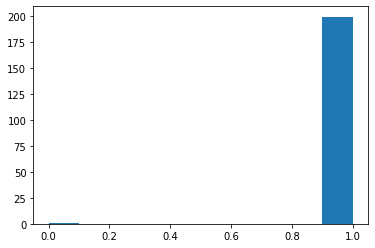

In [19]:
p1 = Satan()
p2 = TitForTat()
# p2 = Jesus()
# p2 = Satan()
# p2 = Arbitrary()
# p2 = MassiveRetalitoryStrike()
# p2 = Tester()
results = run_many_games(p1,p2)
winner, p1_score, p2_score = determine_winner(p1,p2,results)
n, bins, patches = plt.hist(results)